# Goals
For each version of data (z-normalization, log-transform and binarization) from the Data Preprocessing section, fit a logistic regression model with $\ l_2$ regularization. 

For each regularization parameter value λ = {1,2,··· ,9,10,15,20,··· ,95,100} (note the jump in interval from 10 to 15 and beyond), fit the logistic regression model on the training data and compute its error rate (i.e., percentage of emails classified wrongly) on the test data. 

# Data Description

The data is an email spam dataset, consisting of 4601 email messages with 57 features. Feature descriptions are found in this [link](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.info.txt). We have divided the data into a training set (3605 emails) and test set (1536 emails) with accompanying labels (1=spam,0=not spam)

# Setup

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# A function to enable displaying the tables side by side
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

# set seaborn style
sns.set()

# display 6 digit decimal float in Pandas DataFrame
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Implementation

## 1. Import the data

Import the training dataset.

In [2]:
# Creating a DataFrame from csv file for Xtrain. 
df_X = pd.read_csv('spamData_Xtrain.csv',header=None)
# Creating a DataFrame from csv file for ytrain.
df_y = pd.read_csv('spamData_ytrain.csv',header=None)

Import the test dataset

In [3]:
# Creating a DataFrame from csv file for Xtest. 
df_Xtest = pd.read_csv('spamData_Xtest.csv',header=None)
# Creating a DataFrame from csv file for ytest.
df_ytest = pd.read_csv('spamData_ytest.csv',header=None)

`N`: Number of training samples

In [4]:
N = len(df_X)

`D`: Number of training sample features

In [5]:
D = df_X.shape[1]

## 2. Process the data

Three preprocessing technique could be considered:

### 2.1 Z-Normalization

In [6]:
def stdev(column):
    avg = np.mean(column)
    sd  = np.sum(np.square(column-avg))/(len(column)-1)
    return np.sqrt(sd)

def z_norm(column):
    column = column - np.mean(column)
    column = column/stdev(column)
    return column

### 2.2 Log-Transformation 
Transform each feature using $\log(x_{i,j}+0.1)$ (assume natural log)

The log transformation can be used to make highly skewed distributions less skewed.

In [7]:
# df_X = np.log(df_X+0.1)

### 2.3 Binarization

In [8]:
def Binarize(column):
    """For the input column, set values larger than the column mean to be 1, 
    rest set to be 0."""
    ones = column > column.mean()
    zeros = column <= column.mean()
    columnNew = pd.Series(np.zeros(len(column)))
    columnNew[ones] = 1
    return columnNew

### 2.4 Preprocess the training and test dataset

I'll use binarization in this case.

In [9]:
df_X = df_X.apply(Binarize)

In [10]:
df_Xtest = df_Xtest.apply(Binarize)

## 3. Modify `df_X` and `df_w` for Regularization

### 3.1 Add bia term to X.

* df_X

In [11]:
bias = np.ones(N)

In [12]:
df_bias = pd.DataFrame(bias,columns=['bias'])

In [13]:
# Concatenate the bias and df_X coloumn-wise. 
df_X = pd.concat([df_bias,df_X],axis=1)

In [14]:
# Re-arrange the column name
modified_column_name = np.arange(D+1)

In [15]:
df_X.columns = modified_column_name

* df_Xtest

In [16]:
bias_test = np.ones(len(df_Xtest))

In [17]:
df_bias_test = pd.DataFrame(bias_test,columns=['bias'])

In [18]:
# Concatenate the bias and df_X coloumn-wise. 
df_Xtest = pd.concat([df_bias_test,df_Xtest],axis=1)

In [19]:
df_Xtest.columns = modified_column_name

### 3.2 Initialize the modified weight vector

Create and initialize the the weight vector to 0. 

\# weight = # features + 1.

In [20]:
df_w = np.zeros([D+1,1])

In [21]:
df_w = pd.DataFrame(df_w)

## 4. Put everything together
Train the classifier, for each regularization parameter value $\lambda$ = {1,2,...,9,10,15,20,...,95,100}

Then, find the error rates (i.e., percentage of emails classified wrongly) for each $\lambda$.

In [22]:
def sigmoid(x):
  """The sigmoid function"""
  return 1 / (1 + np.exp(-x))

def getErrorRate(prediction,y):
    """Calculate the percentage of emails classified wrongly"""
    compare = prediction == y
    errorRate = 1-compare.sum().values[0]/compare.shape[0]
    return errorRate

def findBestThreshold(pred,y):
    """Calculate error rate for threshold from 50 to 100,
    find the threshold that produces the minimum error rate."""
    # create an array to store the error rate produced by each threshold.
    store = np.zeros(50)
    counter = 0
    for i in np.arange(50,100):
        ones = pred > (i/100)
        pred_binary = pd.DataFrame(ones)
        store[counter] = getErrorRate(pred_binary,y)
        counter = counter +1
    # find the index of the minimum error rate.     
    resultIndex = np.argmin(store)
    bestThreshold = np.arange(50,100)[resultIndex]
    bestErrorRate = store[resultIndex]
    return bestThreshold,bestErrorRate

$I'$- `identity_modified`: set the first entry of the identity matrix $I$ to be 0

In [23]:
identity_modified = np.ones(D+1)
identity_modified[0] = 0 
identity_modified = np.diag(identity_modified)

Regularization parameter value $\lambda$ = {1,2,...,9,10,15,20,...,95,100}

In [24]:
params = np.append(np.arange(1,10),np.arange(10,105,5))

`K` : number of regularization parameter.

In [25]:
K = len(params)

`df_w_all`: a dataframe used to store all the weight vector from each regularization parameter.

In [26]:
df_w_all = pd.DataFrame(np.zeros((D+1,K)),columns=[params])

`df_error_rate`: a dataframed used to store the error rate for each regularization parameter. 

In [27]:
df_error_rate = pd.DataFrame(np.zeros((K,2)),index = params,columns=['train','test'])

In [28]:
for L in params:
    counter  = 0
    for i in np.arange(500):
        #_________________________________________________________#
        ### 1. Calcualte mu 
        df_mu = df_X.dot(df_w)
        df_mu = df_mu.apply(sigmoid)
        
        #_________________________________________________________#
        ### 2. Calculate first derivative of NLL: g 
        df_w_modified = df_w.copy()
        df_w_modified.iloc[0] = 0
        df_g = df_X.transpose().dot(df_mu-df_y)+L*df_w_modified

        #_________________________________________________________#
        ### 3. Calculate second derivative of NLL: H     
        df_S = df_mu*(1-df_mu)
        df_S = np.diag(df_S.transpose().values.tolist()[0])
        df_S = pd.DataFrame(df_S)

        df_H = df_X.transpose().dot(df_S)
        df_H = df_H.dot(df_X)
        df_H = df_H + L*identity_modified
        
        #_________________________________________________________#  
        ### 4. Update weight vector  
        df_H_inverse = pd.DataFrame(np.linalg.pinv(df_H.values))
        df_w_update = df_w - df_H_inverse.dot(df_g)
        
        #_________________________________________________________# 
        ### 5. Check whether the weight vector has already converged.       
        if df_w_update.round(6).equals(df_w.round(6)):
            # Store the converged weight vector.
            df_w_all[L] = df_w[0]
            
            #_____________________________________________________# 
            ### 6. Calculate the error rate for training dataset. 
            df_pred = df_X.dot(df_w)
            df_pred = df_pred.apply(sigmoid)
            threshold,errorRate = findBestThreshold(df_pred,df_y)
            df_error_rate.loc[L,'train'] = errorRate
            
            ### 6. Calculate the error rate for test dataset.
            df_pred = df_Xtest.dot(df_w)
            df_pred = df_pred.apply(sigmoid)
            threshold,errorRate = findBestThreshold(df_pred,df_ytest)
            df_error_rate.loc[L,'test'] = errorRate
            break
        else:
            df_w = df_w_update
            counter = counter + 1

    if counter == 500:
        print('Weight vector didnt converged')
    else:
        print('\nFor regulation parameter',L)
        print('Weight vector converged, training is over.')
        print('Number of loop',counter)

df_w_all = df_w_all.transpose()
print("\nThe weight vector obtained through the newton's method.")
display(df_w_all)


For regulation parameter 1
Weight vector converged, training is over.
Number of loop 8

For regulation parameter 2
Weight vector converged, training is over.
Number of loop 4

For regulation parameter 3
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 4
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 5
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 6
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 7
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 8
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 9
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 10
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 15
Weight vector converged, training is over.
Number of loop 3

For regulation parameter 20
W

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
1,-1.92580,-0.36678,-0.21629,-0.44506,0.54954,1.09004,0.66329,2.62833,0.92609,0.11068,...,-0.48258,0.27090,-0.05700,-0.24255,1.60261,2.02712,-0.61364,0.71648,0.49469,0.39521
2,-1.88934,-0.31297,-0.19908,-0.36338,0.44957,1.01690,0.60968,2.38535,0.87070,0.13230,...,-0.42419,0.25356,-0.05252,-0.22946,1.51290,1.89431,-0.45937,0.65515,0.45018,0.36046
3,-1.86601,-0.27641,-0.17952,-0.30896,0.38680,0.96785,0.57277,2.21369,0.83121,0.14690,...,-0.38507,0.23891,-0.05231,-0.21641,1.45090,1.80096,-0.36179,0.61536,0.42449,0.33742
4,-1.84895,-0.24886,-0.16100,-0.26830,0.34286,0.93073,0.54458,2.08152,0.80031,0.15715,...,-0.35637,0.22590,-0.05378,-0.20492,1.40331,1.72830,-0.29306,0.58574,0.40757,0.32081
5,-1.83547,-0.22685,-0.14414,-0.23598,0.31001,0.90079,0.52181,1.97453,0.77479,0.16456,...,-0.33409,0.21405,-0.05594,-0.19502,1.36451,1.66849,-0.24154,0.56213,0.39552,0.30825
6,-1.82425,-0.20859,-0.12895,-0.20928,0.28431,0.87564,0.50276,1.88501,0.75294,0.17001,...,-0.31612,0.20313,-0.05834,-0.18649,1.33163,1.61748,-0.20126,0.54252,0.38648,0.29839
7,-1.81456,-0.19303,-0.11527,-0.18661,0.26354,0.85394,0.48641,1.80831,0.73376,0.17409,...,-0.30120,0.19300,-0.06077,-0.17908,1.30299,1.57291,-0.16880,0.52576,0.37941,0.29044
8,-1.80596,-0.17949,-0.10292,-0.16699,0.24633,0.83485,0.47214,1.74143,0.71662,0.17717,...,-0.28853,0.18357,-0.06314,-0.17261,1.27754,1.53328,-0.14204,0.51115,0.37370,0.28388
9,-1.79818,-0.16755,-0.09173,-0.14973,0.23179,0.81779,0.45951,1.68229,0.70109,0.17952,...,-0.27760,0.17476,-0.06540,-0.16691,1.25459,1.49755,-0.11956,0.49821,0.36898,0.27836
10,-1.79102,-0.15688,-0.08155,-0.13438,0.21931,0.80237,0.44820,1.62940,0.68686,0.18131,...,-0.26802,0.16651,-0.06753,-0.16185,1.23364,1.46501,-0.10041,0.48660,0.36499,0.27364


In [29]:
print('\nThe error rate when lambda = 1,10 and 100 is\n',df_error_rate.loc[[1,10,100]])


The error rate when lambda = 1,10 and 100 is
       train    test
1   0.06786 0.07031
10  0.07341 0.06966
100 0.09592 0.09115


## 5. Plot the Graph: Error Rates versus $\lambda$

In [30]:
df_error_rate.describe()

,train,test
count,28.00000,28.00000
mean,0.08178,0.07845
std,0.01028,0.00741
min,0.06786,0.06966
25%,0.07162,0.07227
50%,0.08124,0.07585
75%,0.09250,0.08496
max,0.09592,0.09115


In [31]:
# Save the error rates to a csv file.
df_error_rate.to_csv('Q3_ErrorRates_binary.csv')

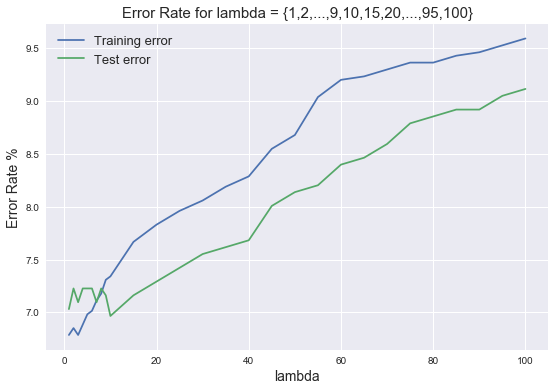

In [32]:
# set the figure size
fig=plt.figure(figsize=(9,6))

# x axis: the regularization parameters lambda.
x = df_error_rate.index.values
# y axis: the error rates
y1 = 100*df_error_rate.train.values
y2 = 100*df_error_rate.test.values

_ = plt.plot(x, y1)
_ = plt.plot(x, y2)

plt.title('Error Rate for lambda = {1,2,...,9,10,15,20,...,95,100}',fontsize=15)
plt.xlabel('lambda', fontsize=14)
plt.ylabel('Error Rate %', fontsize=14)

# legend
plt.legend(('Training error', 'Test error'),fontsize=13)
plt.show()

___